# Prediction: Logistic Regression

> **Warning!** Please run `01_cleaning.ipynb` first if you haven't already

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from functions.constants import BM_NAME, STARTDATE, ENDDATE, N_THRESHOLD_BPS,DATA_DIR
from functions.helper_fns import featurize_time_series 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

In [2]:
active_returns_path = DATA_DIR + BM_NAME + "_active_returns.csv"
active_returns = pd.read_csv(active_returns_path, index_col=0, parse_dates=True)
print("Loaded active returns from", active_returns_path)
active_returns_thresholded_path = DATA_DIR + BM_NAME + "_active_returns_thresholded_" + str(N_THRESHOLD_BPS) + "bps.csv"
active_returns_thresholded = pd.read_csv(active_returns_thresholded_path, index_col=0, parse_dates=True)
print("Loaded active returns thresholded from", active_returns_thresholded_path)

Loaded active returns from ./../data/SP500_active_returns.csv
Loaded active returns thresholded from ./../data/SP500_active_returns_thresholded_100bps.csv


In [3]:
TEST_TICKER = "GS UN" # Goldman Sachs--also try "AAPL UW" and "JPM UN"
test_ticker_df = active_returns_thresholded[active_returns_thresholded["Ticker"] == TEST_TICKER]
test_ticker_df.reset_index(drop=True, inplace=True)
test_ticker_df

,Ticker,Date,active_returns_1b,active_returns_1w,active_returns_1m,active_returns_1q,active_returns_1y
0,GS UN,2021-09-01,0.0,0.0,0.0,0.0,0.0
1,GS UN,2021-02-03,0.0,1.0,1.0,1.0,1.0
2,GS UN,2018-03-29,0.0,0.0,0.0,0.0,0.0
3,GS UN,2022-07-26,0.0,0.0,0.0,0.0,0.0
4,GS UN,2020-08-13,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
2447,GS UN,2015-09-18,0.0,0.0,0.0,0.0,0.0
2448,GS UN,2016-12-19,0.0,0.0,0.0,0.0,0.0
2449,GS UN,2018-08-06,0.0,0.0,0.0,0.0,0.0
2450,GS UN,2022-03-08,0.0,1.0,1.0,1.0,1.0


In [4]:
NUM_FEATURES = 12
PREDICTION_PERIOD = "1w"
MODEL_USING_DF = active_returns_thresholded
# MODEL_USING_DF = test_ticker_df #turn this on to run for one company
df = featurize_time_series(MODEL_USING_DF, PREDICTION_PERIOD, NUM_FEATURES)
target_var = "ar_" + PREDICTION_PERIOD + "_t"
X = df.drop(columns=[target_var, "Date", "Ticker"])
y = df[[target_var]]
print("X shape:", X.shape)
print(X.head())
print("y shape:", y.shape)
print(y.head())
X = X.to_numpy()
y = y.to_numpy()

X shape: (249991, 12)
    ar_1w_t_minus_1  ar_1w_t_minus_2  ar_1w_t_minus_3  ar_1w_t_minus_4  \
12              0.0              0.0              0.0              1.0   
13              0.0              0.0              0.0              0.0   
14              1.0              0.0              0.0              0.0   
15              1.0              1.0              0.0              0.0   
16              0.0              1.0              1.0              0.0   

    ar_1w_t_minus_5  ar_1w_t_minus_6  ar_1w_t_minus_7  ar_1w_t_minus_8  \
12              0.0              0.0              1.0              1.0   
13              1.0              0.0              0.0              1.0   
14              0.0              1.0              0.0              0.0   
15              0.0              0.0              1.0              0.0   
16              0.0              0.0              0.0              1.0   

    ar_1w_t_minus_9  ar_1w_t_minus_10  ar_1w_t_minus_11  ar_1w_t_minus_12  
12          

In [5]:
TEST_FRACTION = 0.2
EVAL_FRACTION = 0.2
X_train_and_eval, X_test, y_train_and_eval, y_test = train_test_split(X, y, test_size=TEST_FRACTION, shuffle=False)
X_train, X_eval, y_train, y_eval = train_test_split(X_train_and_eval, y_train_and_eval, test_size=EVAL_FRACTION/(1-TEST_FRACTION), shuffle=False)
print("X_train shape:", X_train.shape)
print("X_eval shape:", X_eval.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_eval shape:", y_eval.shape)
print("y_test shape:", y_test.shape)

X_train shape: (149994, 12)
X_eval shape: (49998, 12)
X_test shape: (49999, 12)
y_train shape: (149994, 1)
y_eval shape: (49998, 1)
y_test shape: (49999, 1)


## Train a simple Logistic Regression classifier

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_eval)
y_pred_proba = model.predict_proba(X_eval)
print("y_pred shape:", y_pred.shape)
print("y_pred_proba shape:", y_pred_proba.shape)


y_pred shape: (49998,)
y_pred_proba shape: (49998, 2)


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.5134205368214728
Precision: 0.37073462074457497
Recall: 0.5220633585646202
F1: 0.43357392316647264
ROC AUC: 0.520587377055692


Text(0.5, 1.0, 'Confusion Matrix for 1w prediction using 12 Features')

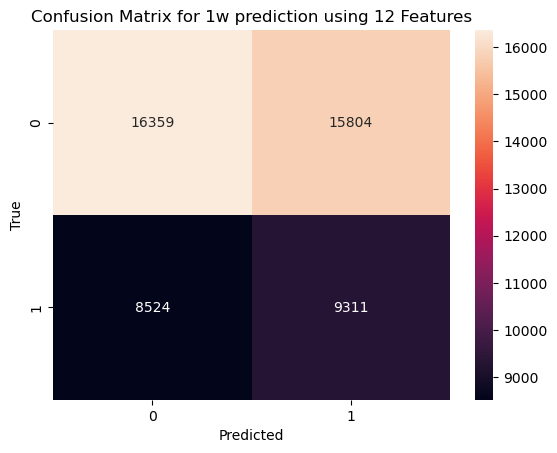

In [8]:
accuracy = accuracy_score(y_eval, y_pred)
precision = precision_score(y_eval, y_pred)
recall = recall_score(y_eval, y_pred)
f1 = f1_score(y_eval, y_pred)
roc_auc = roc_auc_score(y_eval, y_pred_proba[:,1])
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("ROC AUC:", roc_auc)
#show the confusion matrix in a plot using seaborn. 
cm = confusion_matrix(y_eval, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
#print title that mentions the prediction period and num features
plt.title('Confusion Matrix for ' + PREDICTION_PERIOD + " prediction using " + str(NUM_FEATURES) + " Features")